# AL-CPL Prerequisite Learning with FastText Embeddings using GBM


In [1]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score 
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_distances

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from Scripts.util import ExtractIntLabelFromPred

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load the FastText Model

To understand the library, you can look at the documentation available [here](https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters).

In [2]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('Models/cc.en.300.bin')

### Load ACM GBM 0 1 classifier model

In [22]:
gbm_model1 = pickle.load(open("Models/naive_gridsearch_01_classifier.pkl", "rb"))
gbm_model1

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

## Load Data

In [3]:
complete_dataset_csv = pd.read_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_ds.csv")
complete_dataset_csv.tail()

,kw1,kw2,label
6370,natural number,polynomial,0.0
6371,polynomial long division,mathematics,0.0
6372,minor linear algebra,multiplication,0.0
6373,geometry,trigonometric substitution,1.0
6374,integer,homogeneous polynomial,1.0


In [6]:
training_dataset_csv = pd.read_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_training_ds.csv")
training_dataset_csv.tail()

,kw1,kw2,label
4297,zero function,equation,0.0
4298,natural number,polynomial,0.0
4299,polynomial long division,mathematics,0.0
4300,minor linear algebra,multiplication,0.0
4301,integer,homogeneous polynomial,1.0


In [7]:
testing_dataset_csv = pd.read_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_testing_ds.csv")
testing_dataset_csv.tail()

,kw1,kw2,label
2068,trigonometry,trigonometric function,1.0
2069,analytic geometry,plane geometry,0.0
2070,geometry,pythagorean trigonometric identity,1.0
2071,perpendicular,analytic geometry,1.0
2072,geometry,trigonometric substitution,1.0


## Adding Embeddings to data

In [8]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(complete_dataset_csv.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
complete_dataset_csv[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

In [9]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(training_dataset_csv.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
training_dataset_csv[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

In [10]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(testing_dataset_csv.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
testing_dataset_csv[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

## Gradient Boosting

### Standard splitting dtrategy for data

In [11]:
processed_data = complete_dataset_csv.drop(columns=["kw1", "kw2"])#.dropna(subset="ratio")

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(training_data_embedding, processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [12]:
param_test1 = {
    'n_estimators': [700],#range(700, 901, 100),
    'max_depth': [8],#range(8, 13, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [13]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9166887903262874

In [14]:
best_model = gsearch1.best_estimator_

In [15]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [16]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


###### Performance analysis on test dataset

In [17]:
best_model = gsearch1.best_estimator_
y_pred=best_model.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 0.])

In [18]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9271


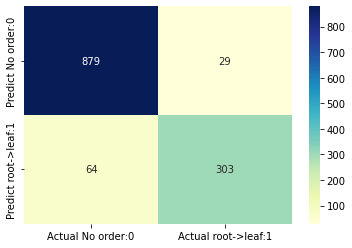

In [20]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       908
         1.0       0.91      0.83      0.87       367

    accuracy                           0.93      1275
   macro avg       0.92      0.90      0.91      1275
weighted avg       0.93      0.93      0.93      1275



##### Saving Best Classifier

In [25]:
pickle.dump(best_model, open("Models/GBM_PrerequisiteLearningClassifier_Pretrained.pkl", "wb"))

#### Comparing with ACM GBM classifier

In [24]:
y_pred=gbm_model1.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7169


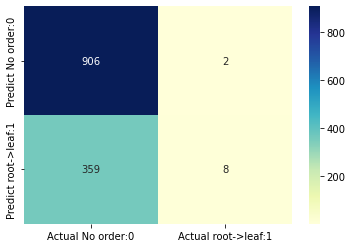

In [26]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.83       908
         1.0       0.80      0.02      0.04       367

    accuracy                           0.72      1275
   macro avg       0.76      0.51      0.44      1275
weighted avg       0.74      0.72      0.61      1275



Quasiment pas de transfer learning. H1: La relation de prérequis est similaire à celle d'inclusion de l'arbre d'ACM est rejetté.

### Tree split of data

In [28]:
processed_data = training_dataset_csv.drop(columns=["kw1", "kw2"])#.dropna(subset="ratio")

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_train, y_train = training_data_embedding, processed_data['label']

In [29]:
processed_data = testing_dataset_csv.drop(columns=["kw1", "kw2"])#.dropna(subset="ratio")

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_test, y_test = training_data_embedding, processed_data['label']

In [30]:
param_test1 = {
    'n_estimators': [700],#range(700, 901, 100),
    'max_depth': [8],#range(8, 13, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [31]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8533219139698727

In [32]:
best_model = gsearch1.best_estimator_

In [33]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [34]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


###### Performance analysis on test dataset

In [35]:
best_model = gsearch1.best_estimator_
y_pred=best_model.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 1.])

In [36]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7791


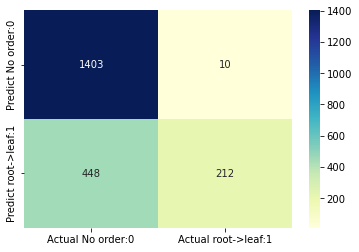

In [37]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86      1413
         1.0       0.95      0.32      0.48       660

    accuracy                           0.78      2073
   macro avg       0.86      0.66      0.67      2073
weighted avg       0.82      0.78      0.74      2073



We can see that with this split strategy the model has a harder time generalizing on the test dataset. It is still less dreadfull than learning on a completely different dataset like the ACM CCS concept tree.

##### Saving Best Classifier

In [39]:
pickle.dump(best_model, open("Models/GBM_PrerequisiteLearningClassifier_Pretrained_TreeSplit.pkl", "wb"))

#### Comparing with ACM GBM classifier

In [40]:
y_pred=gbm_model1.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6840


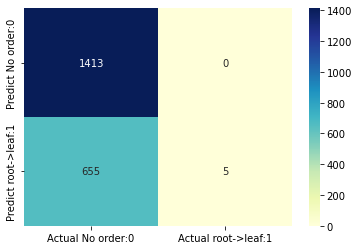

In [42]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      1413
         1.0       1.00      0.01      0.02       660

    accuracy                           0.68      2073
   macro avg       0.84      0.50      0.41      2073
weighted avg       0.78      0.68      0.56      2073



Still a very bad performance on the test dataset !!